<a href="https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Protein structure prediction with AlphaFold2 and MMseqs2

Easy to use version of AlphaFold 2 (Jumper et al. 2021, Nature) using an API hosted at the Södinglab based on the MMseqs2 server (Mirdita et al. 2019, Bioinformatics) for the multiple sequence alignment creation.

**Quickstart**
1. Change the runtime type to GPU at "Runtime" -> "Change runtime type" (improves speed).
2. Paste your protein sequence in the input field below.
3. Press "Runtime" -> "Run all".
4. The pipeline consists of 10 steps. The currently running steps is indicated by a circle with a stop sign next to it.

**Result**

1. PDB formated structures sorted by avg. pIDDT. (relaxed, unrelaxed).
2. Plots of the model quality.
3. Plots of the msa coverage.
4. Parameter log file.
5. A3M formatted input MSA.

At the end of the job a download modal box will popup with a `jobname.result.zip` file.

**Using a custom MSA as input**

To predict the structure with a custom MSA (A3M formatted) (1) Past the input sequence into the "query_sequence" field. (2) Change the msa_mode: to "custom", (3) "Runtime" -> "Run all". (4) A upload box will appear at the end of the "Input Protein ..." box. Upload your A3M. 

To generate good input MSAs HHblits can be used here: https://toolkit.tuebingen.mpg.de/tools/hhblits
Hit submit you query -> click "Query Template MSA" -> "Download Full A3M".
Download the a3m file and upload it to the notebook!

**Troubleshooting**
* Try to restart the session "Runntime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Colab assigns different type of GPUs, some might have not enough memory to predict the structure.
* Browser can block the download of the result.

**Limitations**
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or Mgnify.
* Computing resources: MMseqs2 can probably handle >20k requests per day since we run it only on 16 cores.

For best results, we recommend using the full pipeline: https://github.com/deepmind/alphafold

**Acknowledgements**

Most of the python code was written by Sergey Ovchinnikov (@sokrypton). The API is hosted at the Södinglab (@SoedingL) and maintained by Milot Mirdita (@milot_mirdita). Martin Steinegger (@thesteinegger) integrated everything. Also credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!

For related notebooks see: [ColabFold](https://github.com/sokrypton/ColabFold)

In [18]:
#@title Input protein sequence here before you "Run all"
from google.colab import files
import os
import os.path
import re

query_sequence = 'MAKTIKITQTRSAIGRLPKHKATLLGLGLRRIGHTVEREDTPAIRGMINAVSFMVKVEE' #@param {type:"string"}
# remove whitespaces
query_sequence = "".join(query_sequence.split())
query_sequence = re.sub(r'[^a-zA-Z]','', query_sequence).upper()

jobname = 'RL30_ECOLI' #@param {type:"string"}
# remove whitespaces
jobname = "".join(jobname.split())
jobname = re.sub(r'\W+', '', jobname)

with open(f"{jobname}.fasta", "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

# number of models to use
#@markdown ---
#@markdown ### Advanced settings
num_models = 5 #@param [1,2,3,4,5] {type:"raw"}
msa_mode = "MMseqs2" #@param ["MMseqs2","single_sequence","custom"]
use_msa = True if msa_mode == "MMseqs2" else False
use_custom_msa = True if msa_mode == "custom" else False
use_amber = False #@param {type:"boolean"}
use_templates = False #@param {type:"boolean"}
#@markdown ---

with open(f"{jobname}.log", "w") as text_file:
    text_file.write("num_models=%s\n" % num_models)
    text_file.write("use_amber=%s\n" % use_amber)
    text_file.write("use_msa=%s\n" % use_msa)
    text_file.write("msa_mode=%s\n" % msa_mode)
    text_file.write("use_templates=%s\n" % use_templates)

# decide which a3m to use
if use_msa:
  a3m_file = f"{jobname}.a3m"
elif use_custom_msa:
  a3m_file = f"{jobname}.custom.a3m"
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    os.rename(custom_msa, a3m_file)
    print(f"moving {custom_msa} to {a3m_file}")
else:
  a3m_file = f"{jobname}.single_sequence.a3m"
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [19]:
#@title Install dependencies
%%bash -s $use_amber $use_msa $use_templates

USE_AMBER=$1
USE_MSA=$2
USE_TEMPLATES=$3

if [ ! -f AF2_READY ]; then
  # install dependencies
  pip -q install biopython
  pip -q install dm-haiku
  pip -q install ml-collections
  pip -q install py3Dmol

  # download model
  if [ ! -d "alphafold/" ]; then
    git clone https://github.com/deepmind/alphafold.git --quiet
    mv alphafold alphafold_
    mv alphafold_/alphafold .
    # remove "END" from PDBs, otherwise biopython complains
    sed -i "s/pdb_lines.append('END')//" /content/alphafold/common/protein.py
    sed -i "s/pdb_lines.append('ENDMDL')//" /content/alphafold/common/protein.py
  fi

  # download model params (~1 min)
  if [ ! -d "params/" ]; then
    wget -qnc https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar
    mkdir params
    tar -xf alphafold_params_2021-07-14.tar -C params/
    rm alphafold_params_2021-07-14.tar
  fi
  touch AF2_READY
fi
# download libraries for interfacing with MMseqs2 API
if [ ${USE_MSA} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f MMSEQ2_READY ]; then
    apt-get -qq -y update 2>&1 1>/dev/null
    apt-get -qq -y install jq curl zlib1g gawk 2>&1 1>/dev/null
    touch MMSEQ2_READY
  fi
fi
# setup conda
if [ ${USE_AMBER} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f CONDA_READY ]; then
    wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
    rm Miniconda3-latest-Linux-x86_64.sh
    touch CONDA_READY
  fi
fi
# setup template search
if [ ${USE_TEMPLATES} == "True" ] && [ ! -f HH_READY ]; then
  conda install -y -q -c conda-forge -c bioconda kalign3=3.2.2 hhsuite=3.3.0 python=3.7 2>&1 1>/dev/null
  touch HH_READY
fi
# setup openmm for amber refinement
if [ ${USE_AMBER} == "True" ] && [ ! -f AMBER_READY ]; then
  conda install -y -q -c conda-forge openmm=7.5.1 python=3.7 pdbfixer 2>&1 1>/dev/null
  (cd /usr/local/lib/python3.7/site-packages; patch -s -p0 < /content/alphafold_/docker/openmm.patch)
  wget -qnc https://git.scicore.unibas.ch/schwede/openstructure/-/raw/7102c63615b64735c4941278d92b554ec94415f8/modules/mol/alg/src/stereo_chemical_props.txt
  mv stereo_chemical_props.txt alphafold/common/
  touch AMBER_READY
fi

In [20]:
#@title Call MMseqs2 to get MSA/templates
%%bash -s $use_amber $use_msa $use_templates $jobname
USE_AMBER=$1
USE_MSA=$2
USE_TEMPLATES=$3
NAME=$4
if [ ${USE_MSA} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f ${NAME}.mmseqs2.tar.gz ]; then
    # query MMseqs2 webserver
    echo "submitting job"
    ID=$(curl -s -F q=@${NAME}.fasta -F mode=all https://a3m.mmseqs.com/ticket/msa | jq -r '.id')
    STATUS=$(curl -s https://a3m.mmseqs.com/ticket/${ID} | jq -r '.status')
    while [ "${STATUS}" == "RUNNING" ]; do
      STATUS=$(curl -s https://a3m.mmseqs.com/ticket/${ID} | jq -r '.status')
      sleep 1
    done
    if [ "${STATUS}" == "COMPLETE" ]; then
      curl -s https://a3m.mmseqs.com/result/download/${ID} > ${NAME}.mmseqs2.tar.gz
      tar xzf ${NAME}.mmseqs2.tar.gz
      tr -d '\000' < uniref.a3m > ${NAME}.a3m
      rm uniref.a3m
      mv pdb70.m8 ${NAME}.m8
    else
      echo "MMseqs2 server did not return a valid result."
      cp ${NAME}.fasta ${NAME}.a3m
    fi
  fi
  if [ ${USE_MSA} == "True" ]; then
    echo "Found $(grep -c ">" ${NAME}.a3m) sequences (after redundacy filtering)"
  fi
  if [ ${USE_TEMPLATES} == "True" ] && [ ! -f ${NAME}_hhm.ffindex ]; then
    echo "getting templates"
    if [ -s ${NAME}.m8 ]; then
      if [ ! -d templates ]; then
        mkdir templates/
      fi
      printf "pdb\tevalue\n"
      head -n 20 ${NAME}.m8 | awk '{print $2"\t"$11}'
      TMPL=$(head -n 20 ${NAME}.m8 | awk '{printf $2","}')
      curl -s https://a3m-templates.mmseqs.com/template/${TMPL} | tar xzf - -C templates/
      mv templates/pdb70_a3m.ffdata ${NAME}_a3m.ffdata
      mv templates/pdb70_a3m.ffindex ${NAME}_a3m.ffindex
      mv templates/pdb70_hhm.ffdata ${NAME}_hhm.ffdata
      mv templates/pdb70_hhm.ffindex ${NAME}_hhm.ffindex
      cp ${NAME}_a3m.ffindex ${NAME}_cs219.ffindex
      touch ${NAME}_cs219.ffdata
      echo "hi"
    else
      echo "no templates found"
    fi
  fi
fi

submitting job
Found 3351 sequences (after redundacy filtering)
getting templates
pdb	evalue
6VLZ_Z	2.649E-29
6VMI_Z	2.649E-29
6NU2_Z	4.995E-29
6XYW_Az	1.294E-28
3J6B_U	3.350E-28
5MRF_U	4.601E-28
6SPB_Z	6.318E-28
6SPG_Z	6.318E-28
5NJT_w	2.248E-27
4YBB_C0	3.087E-27
5J8A_C0	3.087E-27
6DZI_a	5.822E-27
1SM1_X	7.997E-27
4IOA_W	7.997E-27
5DM6_W	7.997E-27
5MYJ_B2	2.845E-26
1BXY_B	2.845E-26
4V4J_X	2.845E-26
4WZD_H5	2.845E-26
5O60_a	2.845E-26
hi


tar: pdb70_a3m.ffdata: time stamp 2021-07-21 00:39:34 is 0.132623034 s in the future
tar: pdb70_a3m.ffindex: time stamp 2021-07-21 00:39:34 is 0.125378649 s in the future
tar: pdb70_hhm.ffdata: time stamp 2021-07-21 00:39:34 is 0.038231788 s in the future
tar: pdb70_hhm.ffindex: time stamp 2021-07-21 00:39:34 is 0.03812137 s in the future


In [21]:
#@title Import libraries and setup model
# the following code is written by Sergey Ovchinnikov
# setup the model
if "model" not in dir():

  # hiding warning messages
  import warnings
  from absl import logging
  import os
  import tensorflow as tf
  warnings.filterwarnings('ignore')
  logging.set_verbosity("error")
  os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
  tf.get_logger().setLevel('ERROR')

  import sys
  import numpy as np
  import pickle
  from alphafold.common import protein
  from alphafold.data import pipeline
  from alphafold.data import templates
  from alphafold.model import data
  from alphafold.model import config
  from alphafold.model import model
  from alphafold.data.tools import hhsearch

  # plotting libraries
  import py3Dmol
  import matplotlib.pyplot as plt
  import ipywidgets
  from ipywidgets import interact, fixed

if use_amber and "relax" not in dir():
  sys.path.insert(0, '/usr/local/lib/python3.7/site-packages/')
  from alphafold.relax import relax

if "model_params" not in dir(): model_params = {}
for model_name in ["model_1","model_2","model_3","model_4","model_5"][:num_models]:
  if model_name not in model_params:
    model_config = config.model_config(model_name)
    model_config.data.eval.num_ensemble = 1
    model_params[model_name] = data.get_model_haiku_params(model_name=model_name, data_dir=".")
    if model_name == "model_1":
      model_runner_1 = model.RunModel(model_config, model_params[model_name])
    if model_name == "model_3":
      model_runner_3 = model.RunModel(model_config, model_params[model_name])

def mk_mock_template(query_sequence):
  # since alphafold's model requires a template input
  # we create a blank example w/ zero input, confidence -1
  ln = len(query_sequence)
  output_templates_sequence = "-"*ln
  output_confidence_scores = np.full(ln,-1)
  templates_all_atom_positions = np.zeros((ln, templates.residue_constants.atom_type_num, 3))
  templates_all_atom_masks = np.zeros((ln, templates.residue_constants.atom_type_num))
  templates_aatype = templates.residue_constants.sequence_to_onehot(output_templates_sequence,
                                                                    templates.residue_constants.HHBLITS_AA_TO_ID)
  template_features = {'template_all_atom_positions': templates_all_atom_positions[None],
                       'template_all_atom_masks': templates_all_atom_masks[None],
                       'template_sequence': [f'none'.encode()],
                       'template_aatype': np.array(templates_aatype)[None],
                       'template_confidence_scores': output_confidence_scores[None],
                       'template_domain_names': [f'none'.encode()],
                       'template_release_date': [f'none'.encode()]}
  return template_features

def mk_template(jobname):
  template_featurizer = templates.TemplateHitFeaturizer(
      mmcif_dir="templates/",
      max_template_date="2100-01-01",
      max_hits=20,
      kalign_binary_path="kalign",
      release_dates_path=None,
      obsolete_pdbs_path=None)

  hhsearch_pdb70_runner = hhsearch.HHSearch(binary_path="hhsearch",databases=[jobname])

  a3m_lines = "\n".join(open(f"{jobname}.a3m","r").readlines())
  hhsearch_result = hhsearch_pdb70_runner.query(a3m_lines)
  hhsearch_hits = pipeline.parsers.parse_hhr(hhsearch_result)
  templates_result = template_featurizer.get_templates(query_sequence=query_sequence,
                                                       query_pdb_code=None,
                                                       query_release_date=None,
                                                       hhr_hits=hhsearch_hits)
  return templates_result.features

def set_bfactor(pdb_filename, bfac):
  I = open(pdb_filename,"r").readlines()
  O = open(pdb_filename,"w")
  for line in I:
    if line[0:6] == "ATOM  ":
      seq_id = int(line[23:26].strip()) - 1
      O.write("{prefix}{bfac:6.2f}{suffix}".format(prefix=line[:60], bfac=bfac[seq_id], suffix=line[66:]))
  O.close()

def predict_structure(prefix, feature_dict, do_relax=True, random_seed=0):  
  """Predicts structure using AlphaFold for the given sequence."""

  # Run the models.
  plddts = []
  unrelaxed_pdb_lines = []
  relaxed_pdb_lines = []

  for model_name, params in model_params.items():
    print(f"running {model_name}")
    # swap params to avoid recompiling
    # note: models 1,2 have diff number of params compared to models 3,4,5
    if any(str(m) in model_name for m in [1,2]): model_runner = model_runner_1
    if any(str(m) in model_name for m in [3,4,5]): model_runner = model_runner_3
    model_runner.params = params
    
    processed_feature_dict = model_runner.process_features(feature_dict, random_seed=random_seed)
    prediction_result = model_runner.predict(processed_feature_dict)
    unrelaxed_protein = protein.from_prediction(processed_feature_dict,prediction_result)
    unrelaxed_pdb_lines.append(protein.to_pdb(unrelaxed_protein))
    plddts.append(prediction_result['plddt'])

    if do_relax:
      # Relax the prediction.
      amber_relaxer = relax.AmberRelaxation(max_iterations=0,tolerance=2.39,
                                            stiffness=10.0,exclude_residues=[],
                                            max_outer_iterations=20)      
      relaxed_pdb_str, _, _ = amber_relaxer.process(prot=unrelaxed_protein)
      relaxed_pdb_lines.append(relaxed_pdb_str)

  # rerank models based on predicted lddt
  lddt_rank = np.mean(plddts,-1).argsort()[::-1]
  plddts_ranked = {}
  for n,r in enumerate(lddt_rank):
    print(f"model_{n+1} {np.mean(plddts[r])}")

    unrelaxed_pdb_path = f'{prefix}_unrelaxed_model_{n+1}.pdb'    
    with open(unrelaxed_pdb_path, 'w') as f: f.write(unrelaxed_pdb_lines[r])
    set_bfactor(unrelaxed_pdb_path,plddts[r]/100)

    if do_relax:
      relaxed_pdb_path = f'{prefix}_relaxed_model_{n+1}.pdb'
      with open(relaxed_pdb_path, 'w') as f: f.write(relaxed_pdb_lines[r])
      set_bfactor(relaxed_pdb_path,plddts[r]/100)

    plddts_ranked[f"model_{n+1}"] = plddts[r]

  return plddts_ranked

In [22]:
#@title Gather input features, predict structure
# parse TEMPLATES
if use_templates and os.path.isfile(f"{jobname}_hhm.ffindex"):
  template_features = mk_template(jobname)
else:
  template_features = mk_mock_template(query_sequence)

# parse MSA
a3m_lines = "".join(open(a3m_file,"r").readlines())
msa, deletion_matrix = pipeline.parsers.parse_a3m(a3m_lines)

if len(query_sequence) != len(msa[0]):
  print(f"ERROR: the length of query ({len(query_sequence)}) does not match length of MSA sequences ({len(msa[0])})")

# gather features
feature_dict = {
    **pipeline.make_sequence_features(sequence=query_sequence,
                                      description="none",
                                      num_res=len(query_sequence)),
    **pipeline.make_msa_features(msas=[msa],deletion_matrices=[deletion_matrix]),
    **template_features
}
plddts = predict_structure(jobname, feature_dict, do_relax=use_amber)

running model_1
model_1 92.70762565834725


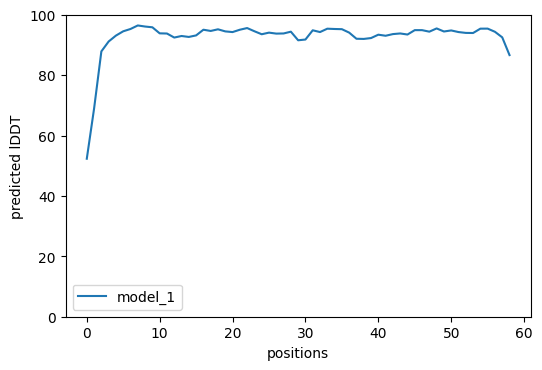

In [23]:
#@title Plot lDDT per residue
# confidence per position
plt.figure(dpi=100)
for model_name,value in plddts.items():
  plt.plot(value,label=model_name)
plt.legend()
plt.ylim(0,100)
plt.ylabel("predicted lDDT")
plt.xlabel("positions")
plt.savefig(jobname+"_lDDT.png")
plt.show()

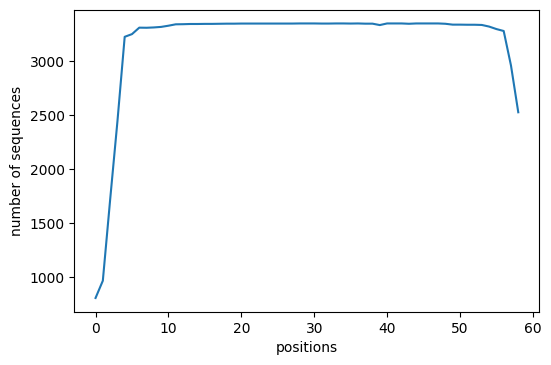

In [24]:
#@title Plot Number of Sequences per Position
# confidence per position
plt.figure(dpi=100)
plt.plot((feature_dict["msa"] != 21).sum(0))
plt.xlabel("positions")
plt.ylabel("number of sequences")
plt.savefig(jobname+"_msa_coverage.png")
plt.show()

In [25]:
#@title Show 3D structure
def show_pdb(model_name,
             show_sidechains=False,
             show_mainchain=False,
             color="None"):

  def mainchain(p, color="white", model=0):
    BB = ['C','O','N','CA']
    p.addStyle({"model":model,'atom':BB},
                       {'stick':{'colorscheme':f"{color}Carbon",'radius':0.4}})

  def sidechain(p, model=0):
    HP = ["ALA","GLY","VAL","ILE","LEU","PHE","MET","PRO","TRP","CYS","TYR"]
    BB = ['C','O','N']
    p.addStyle({"model":model,'and':[{'resn':HP},{'atom':BB,'invert':True}]},
              {'stick':{'colorscheme':"yellowCarbon",'radius':0.4}})
    p.addStyle({"model":model,'and':[{'resn':"GLY"},{'atom':'CA'}]},
              {'sphere':{'colorscheme':"yellowCarbon",'radius':0.4}})
    p.addStyle({"model":model,'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
              {'stick':{'colorscheme':"yellowCarbon",'radius':0.4}})  
    p.addStyle({"model":model,'and':[{'resn':HP,'invert':True},{'atom':BB,'invert':True}]},
              {'stick':{'colorscheme':"whiteCarbon",'radius':0.4}})

  if use_amber:
    pdb_filename = f"{jobname}_relaxed_{model_name}.pdb"
  else:
    pdb_filename = f"{jobname}_unrelaxed_{model_name}.pdb"

  p = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  p.addModel(open(pdb_filename,'r').read(),'pdb')
  if color == "lDDT":
    p.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':1}}})
  elif color == "rainbow":
    p.setStyle({'cartoon': {'color':'spectrum'}})
  else:
    p.setStyle({'cartoon':{}})

  if show_sidechains: sidechain(p)
  if show_mainchain: mainchain(p)
  p.zoomTo()
  return p.show()

interact(show_pdb,
         model_name=ipywidgets.Dropdown(options=model_params.keys(), value='model_1'),
         show_sidechains=ipywidgets.Checkbox(value=False),
         show_mainchain=ipywidgets.Checkbox(value=False),
         color=ipywidgets.Dropdown(options=['None', 'rainbow', 'lDDT'], value='lDDT'))

interactive(children=(Dropdown(description='model_name', options=('model_1',), value='model_1'), Checkbox(valu…

<function __main__.show_pdb>

In [26]:
#@title Package and download results
!zip -FSr $jobname".result.zip" $jobname".log" $a3m_file $jobname"_msa_coverage.png" $jobname"_"*"relaxed_model_"*".pdb" $jobname"_lDDT.png"
files.download(f"{jobname}.result.zip")

  adding: RL30_ECOLI.log (deflated 18%)
  adding: RL30_ECOLI.a3m (deflated 65%)
  adding: RL30_ECOLI_msa_coverage.png (deflated 10%)
  adding: RL30_ECOLI_unrelaxed_model_1.pdb (deflated 78%)
  adding: RL30_ECOLI_lDDT.png (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Instructions
- If you having issues downloading results, try disable adblocker and run the last cell again. If that fails click on the little folder icon to the left, navigate to file:`jobname.result.zip`, right-click and select "download".